In [1]:
import tensorflow as tf
from dataloader import Dataset
from data_generator import FrameGenerator
from model import build_model
from tensorflow import keras
import seaborn as sns
import matplotlib.pyplot as plt

2023-03-19 20:24:42.433389: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
data, classes = Dataset(
    dataset_path="dataset/UCF-101", 
    num_classes=40, 
    splits={"train": 60, "val": 50, "test": 100}
    )
    
for split in data.keys():
    print(split, len(data[split]))

Total Number of Videos: 5313
train 3175
val 1061
test 1077


In [3]:
n_frames = 10
batch_size = 8

output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

FrameGenerator(data['train'], n_frames, classes, training=True)

train_ds = tf.data.Dataset.from_generator(FrameGenerator(data['train'], n_frames, classes, training=True), output_signature = output_signature)
train_ds = train_ds.batch(batch_size)

val_ds = tf.data.Dataset.from_generator(FrameGenerator(data['val'], n_frames, classes), output_signature = output_signature)
val_ds = val_ds.batch(batch_size)

test_ds = tf.data.Dataset.from_generator(FrameGenerator(data['test'], n_frames, classes), output_signature = output_signature)
test_ds = test_ds.batch(batch_size)

2023-03-19 20:24:46.865505: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-03-19 20:24:46.868208: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-03-19 20:24:47.041236: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:927] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-19 20:24:47.041273: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:2b:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.71GHz coreCount: 30 deviceMemorySize: 6.00GiB deviceMemoryBandwidth: 312.97GiB/s
2023-03-19 20:24:47.041285: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-03-19 20:24:47.075927: I tensorflow/stream_executor/platfor

In [4]:
HEIGHT = 224
WIDTH = 224
input_shape = (None, 10, HEIGHT, WIDTH, 3)

model = build_model(input_shape[1:])

frames, label = next(iter(train_ds))

model.build(frames)

model.compile(loss = keras.losses.SparseCategoricalCrossentropy(), 
              optimizer = keras.optimizers.Adam(learning_rate = 0.0001), 
              metrics = ['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 8, 222, 222, 16)   1312      
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 6, 220, 220, 32)   13856     
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 4, 218, 218, 64)   55360     
_________________________________________________________________
dropout (Dropout)            (None, 4, 218, 218, 64)   0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 2, 216, 216, 64)   110656    
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 1, 108, 108, 64)   0         
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 746496)         0

2023-03-19 20:24:53.581984: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-03-19 20:24:53.582362: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3600010000 Hz


In [8]:
import pydot

In [9]:
# Visualize the model
keras.utils.plot_model(model, expand_nested=True, dpi=60, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [10]:
tf.__version__

'2.4.1'

In [11]:
model.load_weights("checkpoints/cp-0005.ckpt")

2023-03-19 20:25:52.420368: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 382205952 exceeds 10% of free system memory.
2023-03-19 20:25:52.892402: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 382205952 exceeds 10% of free system memory.
2023-03-19 20:25:53.284644: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 382205952 exceeds 10% of free system memory.


In [12]:
model.evaluate(test_ds, return_dict=True)

2023-03-19 20:25:59.314070: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-03-19 20:26:00.404035: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


135/135 [==============================] - 83s 585ms/step - loss: 0.4933 - accuracy: 0.9487


{'loss': 0.464447557926178, 'accuracy': 0.9545032382011414}

In [15]:
history = model.history

KeyError: 'loss'

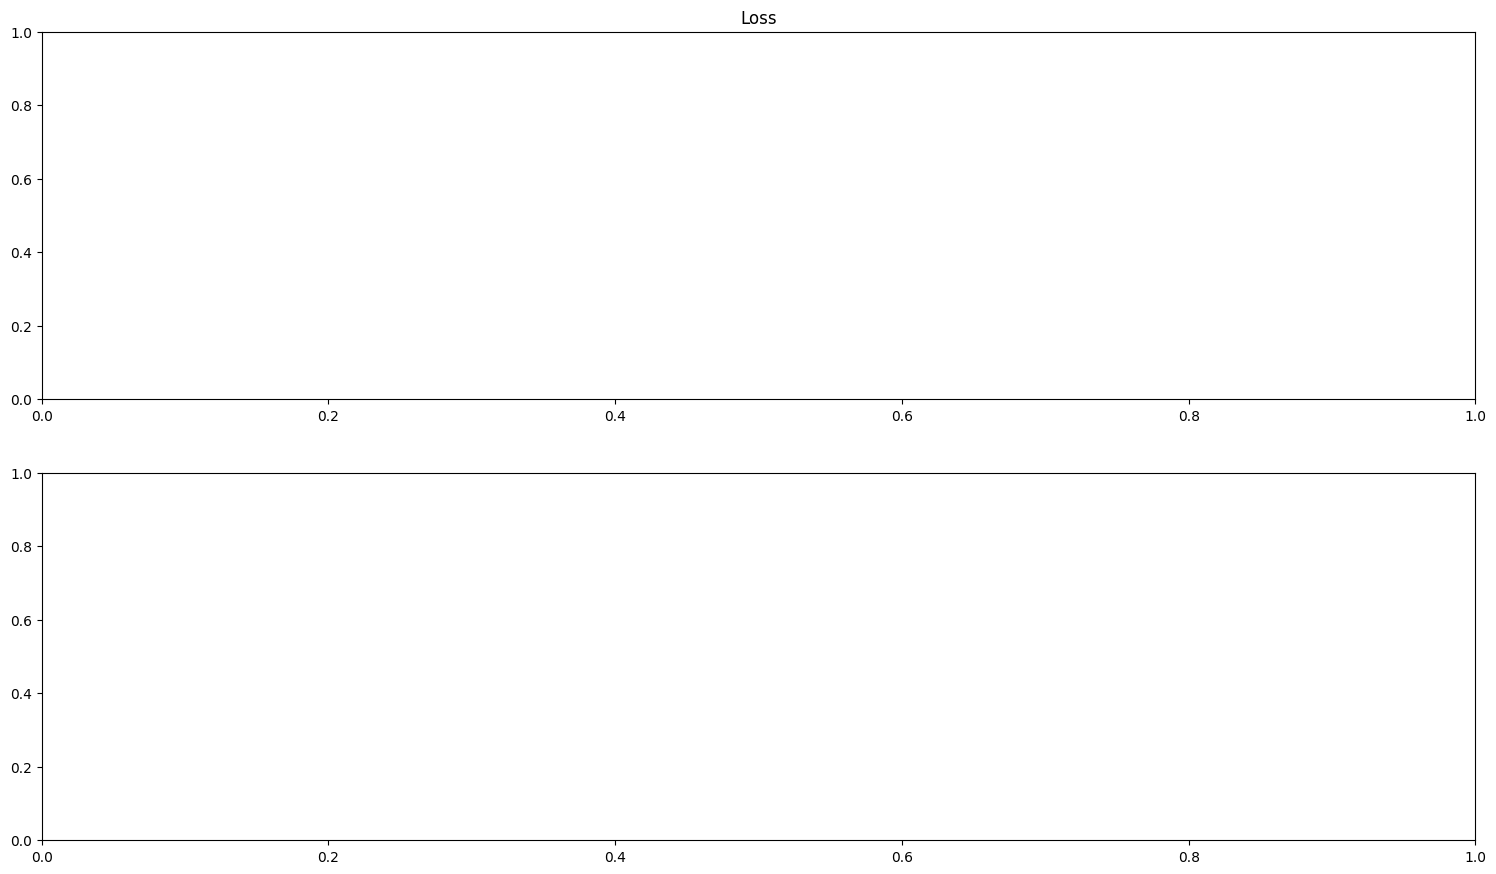

In [17]:
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(2)

  fig.set_size_inches(18.5, 10.5)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')

  # Determine upper bound of y-axis
  max_loss = max(history.history['loss'] + history.history['val_loss'])

  ax1.set_ylim([0, np.ceil(max_loss)])
  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation']) 

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_ylim([0, 1])
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])

  plt.show()

plot_history(history)


In [ ]:
hist = model.history
plot_history(hist)

In [18]:
def get_actual_predicted_labels(dataset): 
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

In [40]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
      cm = tf.math.confusion_matrix(actual, predicted)
      ax = sns.heatmap(cm, annot=True, fmt='g')
      sns.set(rc={'figure.figsize':(30, 30)})
      sns.set(font_scale=1.4)
      ax.set_title('Confusion matrix of action recognition for ' + ds_type)
      ax.set_xlabel('Predicted Action')
      ax.set_xticks(range(40))
      ax.set_ylabel('Actual Action')
      ax.set_yticks(range(40))
      plt.xticks(rotation=90)
      plt.yticks(rotation=0)
      ax.xaxis.set_ticklabels(labels)
      ax.yaxis.set_ticklabels(labels)

In [34]:
actual, predicted = get_actual_predicted_labels(test_ds)


KeyboardInterrupt: 

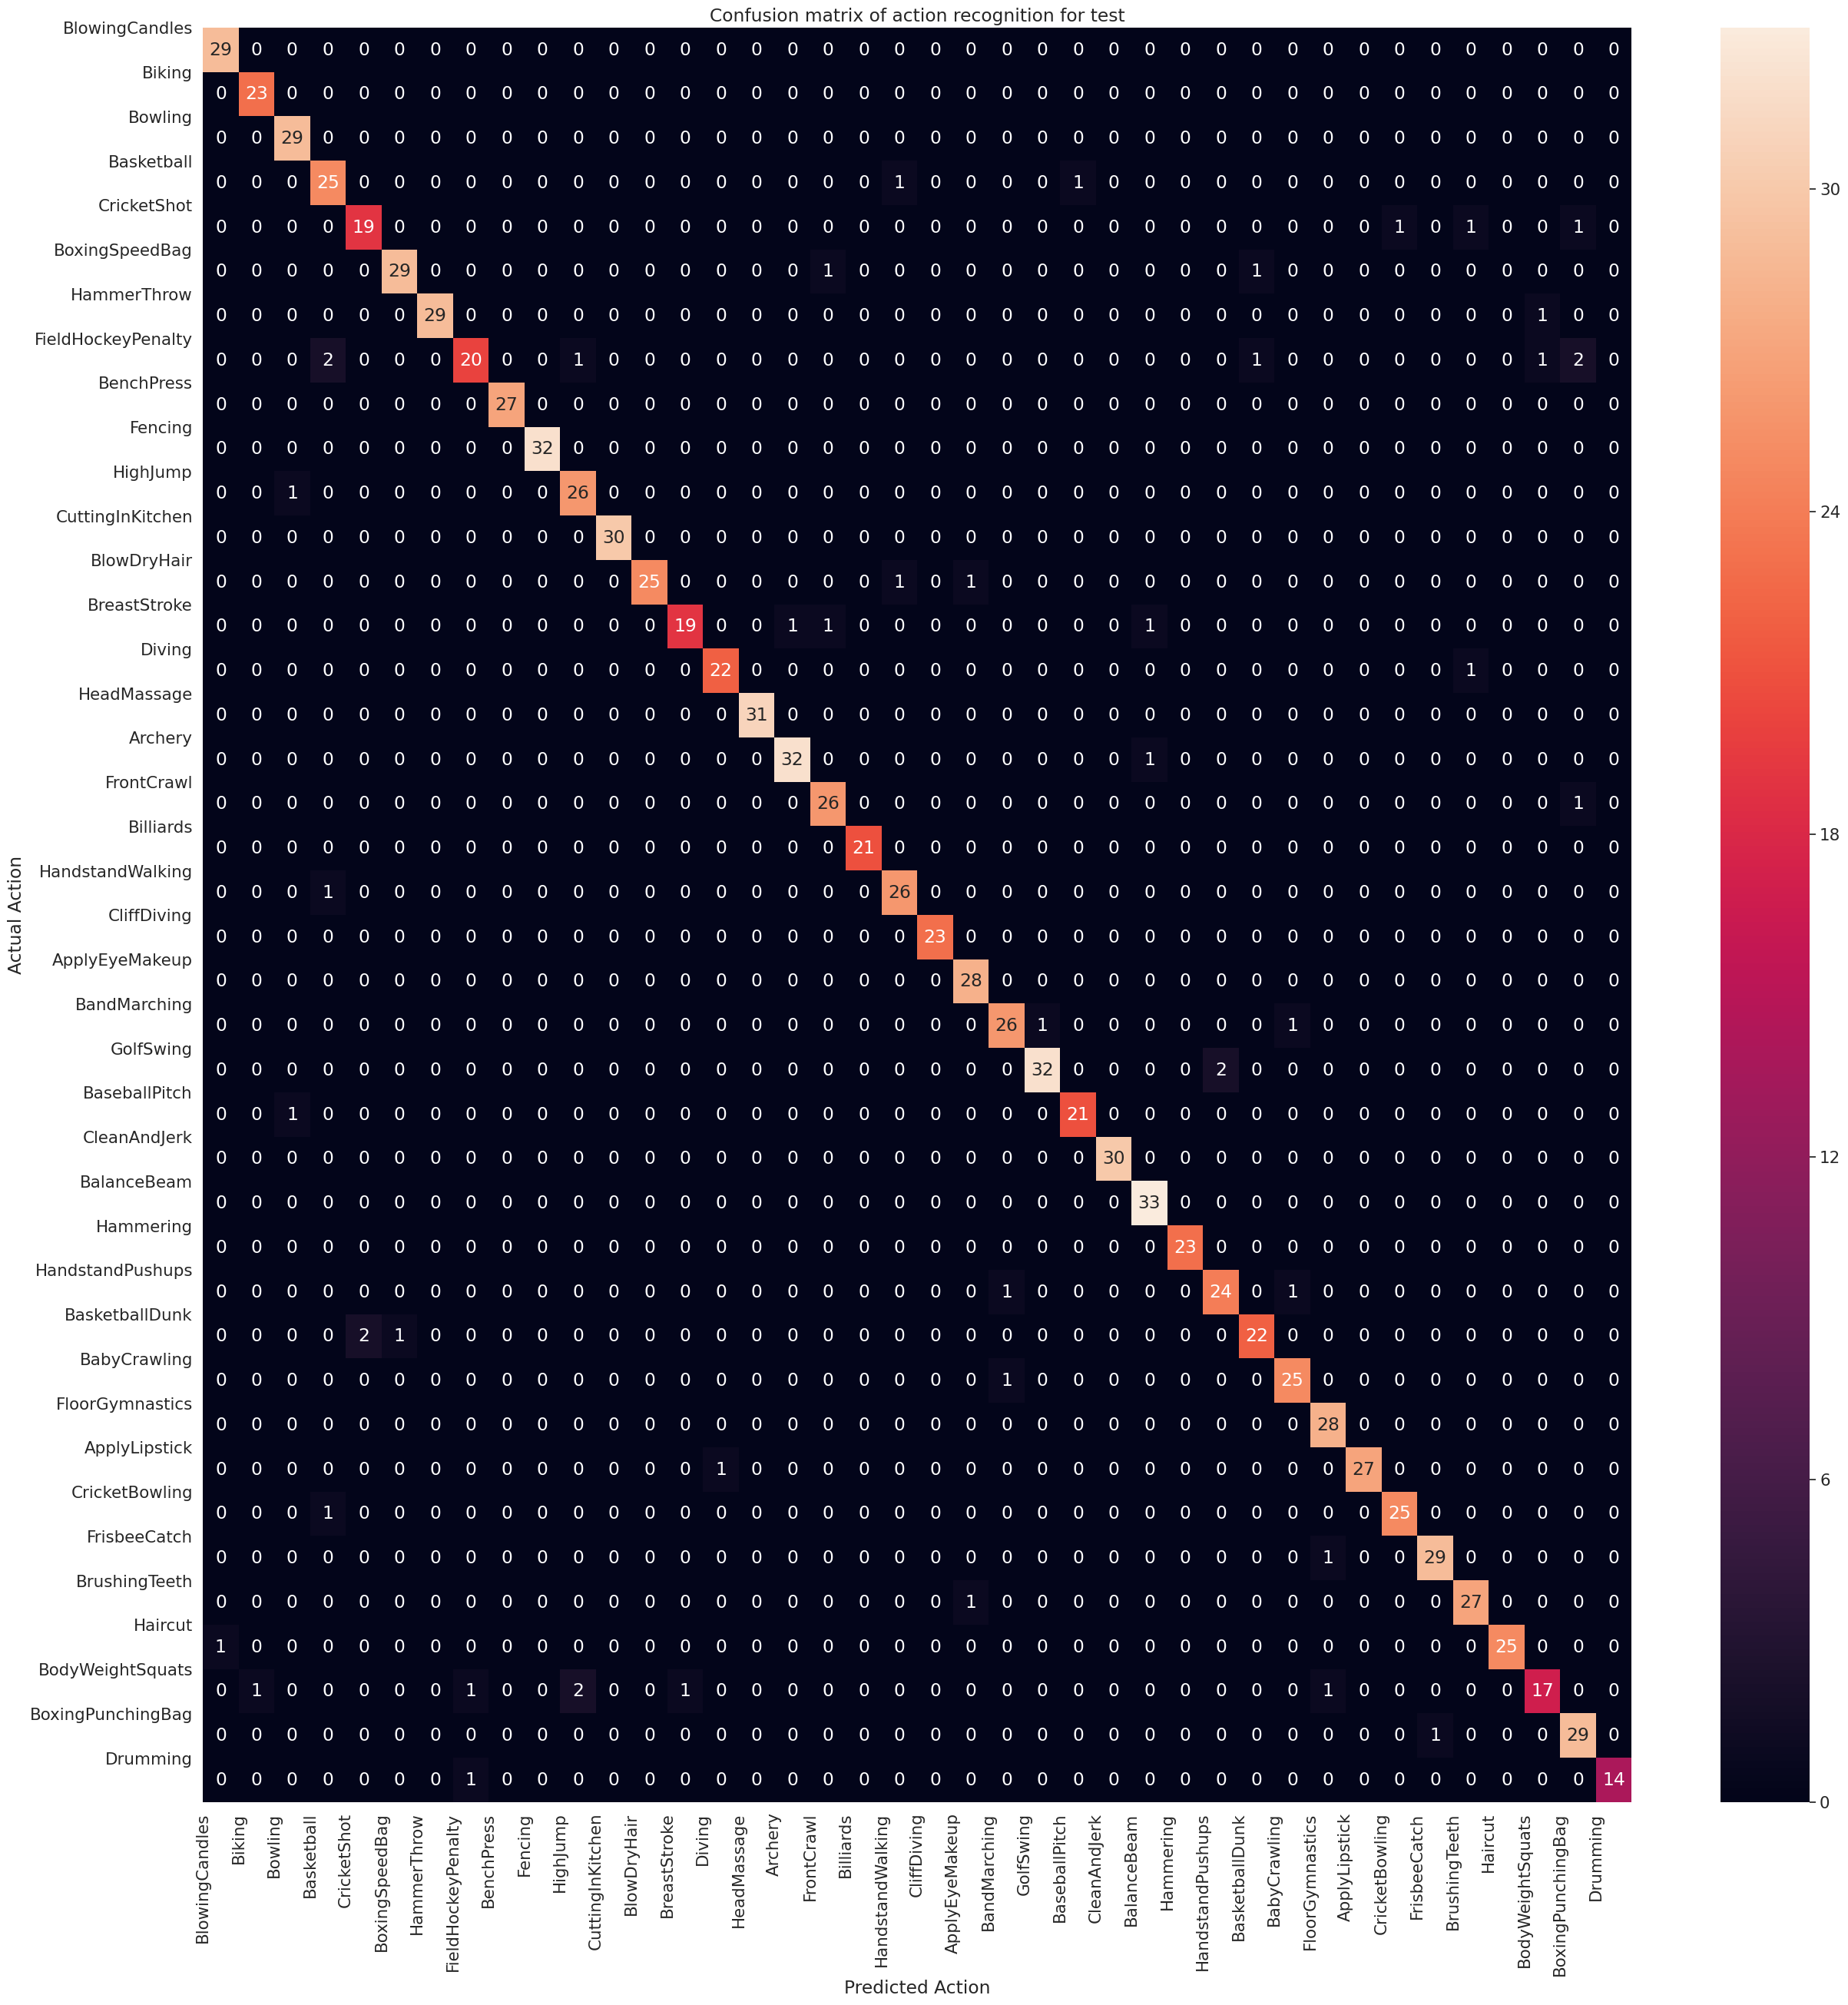

In [41]:
plot_confusion_matrix(actual, predicted, classes, 'test')

In [22]:
def calculate_classification_metrics(y_actual, y_pred, labels):
  """
    Calculate the precision and recall of a classification model using the ground truth and
    predicted values. 

    Args:
      y_actual: Ground truth labels.
      y_pred: Predicted labels.
      labels: List of classification labels.

    Return:
      Precision and recall measures.
  """
  cm = tf.math.confusion_matrix(y_actual, y_pred)
  tp = np.diag(cm) # Diagonal represents true positives
  precision = dict()
  recall = dict()
  for i in range(len(labels)):
    col = cm[:, i]
    fp = np.sum(col) - tp[i] # Sum of column minus true positive is false negative

    row = cm[i, :]
    fn = np.sum(row) - tp[i] # Sum of row minus true positive, is false negative

    precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision 

    recall[labels[i]] = tp[i] / (tp[i] + fn) # Recall

  return precision, recall

In [25]:
import numpy as np
precision, recall = calculate_classification_metrics(actual, predicted, classes)

In [26]:
precision

{'BlowingCandles': 0.9666666666666667,
 'Biking': 0.9583333333333334,
 'Bowling': 0.9354838709677419,
 'Basketball': 0.8620689655172413,
 'CricketShot': 0.9047619047619048,
 'BoxingSpeedBag': 0.9666666666666667,
 'HammerThrow': 1.0,
 'FieldHockeyPenalty': 0.9090909090909091,
 'BenchPress': 1.0,
 'Fencing': 1.0,
 'HighJump': 0.896551724137931,
 'CuttingInKitchen': 1.0,
 'BlowDryHair': 1.0,
 'BreastStroke': 0.95,
 'Diving': 0.9565217391304348,
 'HeadMassage': 1.0,
 'Archery': 0.9696969696969697,
 'FrontCrawl': 0.9285714285714286,
 'Billiards': 1.0,
 'HandstandWalking': 0.9285714285714286,
 'CliffDiving': 1.0,
 'ApplyEyeMakeup': 0.9333333333333333,
 'BandMarching': 0.9285714285714286,
 'GolfSwing': 0.9696969696969697,
 'BaseballPitch': 0.9545454545454546,
 'CleanAndJerk': 1.0,
 'BalanceBeam': 0.9428571428571428,
 'Hammering': 1.0,
 'HandstandPushups': 0.9230769230769231,
 'BasketballDunk': 0.9166666666666666,
 'BabyCrawling': 0.9259259259259259,
 'FloorGymnastics': 0.9333333333333333,
 'A

In [27]:
recall

{'BlowingCandles': 1.0,
 'Biking': 1.0,
 'Bowling': 1.0,
 'Basketball': 0.9259259259259259,
 'CricketShot': 0.8636363636363636,
 'BoxingSpeedBag': 0.9354838709677419,
 'HammerThrow': 0.9666666666666667,
 'FieldHockeyPenalty': 0.7407407407407407,
 'BenchPress': 1.0,
 'Fencing': 1.0,
 'HighJump': 0.9629629629629629,
 'CuttingInKitchen': 1.0,
 'BlowDryHair': 0.9259259259259259,
 'BreastStroke': 0.8636363636363636,
 'Diving': 0.9565217391304348,
 'HeadMassage': 1.0,
 'Archery': 0.9696969696969697,
 'FrontCrawl': 0.9629629629629629,
 'Billiards': 1.0,
 'HandstandWalking': 0.9629629629629629,
 'CliffDiving': 1.0,
 'ApplyEyeMakeup': 1.0,
 'BandMarching': 0.9285714285714286,
 'GolfSwing': 0.9411764705882353,
 'BaseballPitch': 0.9545454545454546,
 'CleanAndJerk': 1.0,
 'BalanceBeam': 1.0,
 'Hammering': 1.0,
 'HandstandPushups': 0.9230769230769231,
 'BasketballDunk': 0.88,
 'BabyCrawling': 0.9615384615384616,
 'FloorGymnastics': 1.0,
 'ApplyLipstick': 0.9642857142857143,
 'CricketBowling': 0.961

In [30]:
print(tf.math.confusion_matrix(actual, predicted))

tf.Tensor(
[[29  0  0 ...  0  0  0]
 [ 0 23  0 ...  0  0  0]
 [ 0  0 29 ...  0  0  0]
 ...
 [ 0  1  0 ... 17  0  0]
 [ 0  0  0 ...  0 29  0]
 [ 0  0  0 ...  0  0 14]], shape=(40, 40), dtype=int32)
